<a href="https://colab.research.google.com/github/hasan-rakibul/speech-efr-eeg/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
################### Google Drive Mounting #############
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
def fir_coeff(fs, filter_type, freq_edge_arr, trans_width=None, trans_slope_dbper_octave=None, window_function_type=None, pass_ripple_db=0.00275, stop_atten_db=70):
  # In case of FIR filter design bandedge and cut-off frequency are different.
  # Usually, the cut-off frequency = (pass-band edge+stop-band edge)/2. If frequency range a-b is given, it means these are bandeges
  # If information is like pass-band is a-b and stop-band is c-d. Then cut-off frequency is (b+c)/2 and transiton width=c-b
  # But if only the pass-band edge and transition slope (db/octave) are mentioned,
  # transition width=(pass-band edge)*6db/trans_slope_dbper_octave
  # Sometime cut-off frequency and transition width are mentioned


  ################## Input Argument Descriptions ###############
  # filter_type=1 indicates Low Pass, filter_type=2 indicates High Pass, filter_type=3 indicates Band pass, filter_type=4 indicates Band stop

  ########################## Window function type ###################################
  # 1-Rectangular Window, 2-Hanning Window, 3-Hamming Window, 4-Blackman Window, 5-Kaiser Window

    assert(type(filter_type) is int),"Only integers are allowed" #Filter type have to provide as integer

    assert(filter_type>=1 and filter_type<=4),"Filter type should be: 1<=filter_type<=4" #Filter type value should be 1<=filter_type<=4
    #########################Start of Cut-off frequency and transitional width selection process for Low and High pass filter ####################
    if filter_type==1 or filter_type==2:
        if len(freq_edge_arr)==2 and trans_width is None:
            width=freq_edge_arr[1]-freq_edge_arr[0]
            fcut=(freq_edge_arr[1]+freq_edge_arr[0])/2
        elif len(freq_edge_arr)==1 and trans_slope_dbper_octave is None and len(trans_width)==1:
            width=trans_width[0]
            fcut=freq_edge_arr[0]
        elif len(freq_edge_arr)==1 and trans_width is None and trans_slope_dbper_octave is not None:
            assert(len(trans_slope_dbper_octave)==1), "For Low and High pass filter transition slop value will be one"
            width= freq_edge_arr[0]*6/trans_slope_dbper_octave[0]
            fcut=freq_edge_arr[0]
        elif len(freq_edge_arr)==2 and trans_slope_dbper_octave is not None:
            raise ValueError('For Low pass or High pass filter two Bandedges are enough, providing transitional slope creats confusion')

        elif len(freq_edge_arr)==2 and trans_width is not None:
            raise ValueError('For Low pass or High pass filter two Bandedges are enough, providing transitional width creats confusion')

        elif trans_slope_dbper_octave is not None and trans_width is not None:
            raise ValueError('Both transitional width and transitional slope are provided which creats confusing')
        else:
            raise ValueError('Confusing information provided or sufficient information missing')
######################### End  of Cut-off frequency and transitional width selection process for Low and High pass filter ####################

######################### Start of Cut-off frequency and transitional width selection process for Band-pass and Band-stop pass filter ####################
    elif filter_type==3 or filter_type==4:
        assert(len(freq_edge_arr)>=2),"For Band-pass and band-stopfilter there should be two edge frequencies"
        if len(freq_edge_arr)==4 and trans_width is None:
            width1=freq_edge_arr[1]-freq_edge_arr[0]
            width2=freq_edge_arr[3]-freq_edge_arr[2]
            width=min(width1,width2)
            fcut1=(freq_edge_arr[1]+freq_edge_arr[0])/2
            fcut2=(freq_edge_arr[3]+freq_edge_arr[2])/2
            fcut=[fcut1,fcut2]


        elif len(freq_edge_arr)==2 and trans_slope_dbper_octave is None and len(trans_width)==2:
            width=min(trans_width[0],trans_width[1])
            fcut=freq_edge_arr

        elif len(freq_edge_arr)==2 and trans_width is None and len(trans_slope_dbper_octave)==2:
            width1= freq_edge_arr[0]*6/trans_slope_dbper_octave[0]
            width2= freq_edge_arr[1]*6/trans_slope_dbper_octave[1]
            width=min(width1,width2)
            fcut=freq_edge_arr

        elif len(freq_edge_arr)==4 and trans_slope_dbper_octave is not None:
            raise ValueError('For band pass or stop filter Four Bandedges has been provided, in this situation providing transitional BW creats confusing ')

        elif len(freq_edge_arr)==4 and trans_width is not None:
            raise ValueError('For band pass or stop filter Four Bandedges has been provided, in this situation providing transitional slope creats confusing')

        elif trans_slope_dbper_octave is not None and trans_width is not None:
            raise ValueError('Both transitional width and transitional slope are provided which creats confusing')

        else:
          raise ValueError('Confusing information provided or sufficient information missing')


######################### End of Cut-off frequency and transitional width selection process for Band-pass and Band-stop pass filter ####################

######################### Start of window function selection process ####################################

    if window_function_type is not None and pass_ripple_db is not None and stop_atten_db is not None:
        assert(type(window_function_type) is int),"Window function type should be intger: 1-Rectangular Window, 2-Hanning Window, 3-Hamming Window, 4-Blackman Window, 5-Kaiser Window"
        if window_function_type==1:
            assert(pass_ripple_db>=0.7416 and stop_atten_db<=21),"For rectangular window the pass-band ripple should not less than 0.7416 dB and stop-band attenuation should not be higher than 21dB "
        elif window_function_type==2:
            assert(pass_ripple_db>=0.0546 and stop_atten_db<=44), "For Hanning window the pass-band ripple should not less than 0.0546 dB and stop-band attenuation should not be higher than 44dB"
        elif window_function_type==3:
            assert(pass_ripple_db>=0.0194 and stop_atten_db<=53), "For Hamming window the pass-band ripple should not less than 0.0194 dB and stop-band attenuation should not be higher than 53dB "
        elif window_function_type==4:
            assert(pass_ripple_db>=0.0017 and stop_atten_db<=75), "For Blackman window the pass-band ripple should not less than 0.0017 dB and stop-band attenuation should not be higher than 75dB"
        elif window_function_type==5:
            assert(pass_ripple_db>=0.000275 and stop_atten_db<=90), "For Kaiser window the pass-band ripple should not less than 0.0274 dB and stop-band attenuation should not be higher than 90dB"
        else:
            raise ValueError('Invalide window function')

    elif window_function_type==None and pass_ripple_db is not None and stop_atten_db is not None:
        #assert(type(pass_ripple_db) is int or type(pass_ripple_db) is float), 'Pass Band ripple must be numerical data'
       # assert(type(pass_ripple_db) is int or type(pass_ripple_db) is float), 'Pass Band ripple must be numerical data'

        if pass_ripple_db>0.0546 and stop_atten_db<44:
            window_function_type=1
        elif pass_ripple_db>0.0194 and stop_atten_db<53:
            window_function_type=2
        elif pass_ripple_db>0.0017 and stop_atten_db<75:
            window_function_type=3
        elif pass_ripple_db>0.000275 and stop_atten_db<90:
            window_function_type=4
        elif pass_ripple_db>=0.000275 and stop_atten_db<=90:
            window_function_type=5
        else:
            raise ValueError('Passband ripple should be >0.000275 dB and stop-band attenuation <90dB')

    else:
        raise ValueError('Insufficient information about window function type, or passband ripple and stop-band attenuation')
######################### End of window function selection process####################################

############################# start of ripple factor selection########################################

    #20log(1+\delta_pass)=pass_ripple_db
    #log(1+\delta_pass)= pass_ripple_db/20
    #1+\delta_pass=10**(pass_ripple_db/20)
    #\delta_pass=10**(pass_ripple_db/20)-1
    ripple_PB=10**(pass_ripple_db/20)-1

    #stop_atten_db=-20log\delta_st
    #\delta_st=10**(-stop_atten_db/20)
    ripple_stop=10**(-stop_atten_db/20)


    ripple=min(ripple_PB,ripple_stop)#Minimum ripple factor will be considered
 ############################# End of ripple factor selection########################################

    trans_width_norm=width/fs # transitional width is required for estimation of number of taps or number of FIR coefficient


 ######################### Start of Number of tap calculation for different window function#######################################

    if window_function_type==1:
        numtaps=np.round(0.9/trans_width_norm)
        window='boxcar'
    elif window_function_type==2:
        numtaps=np.round(3.1/trans_width_norm)
        window='hann'
    elif window_function_type==3:
        numtaps=np.round(3.3/trans_width_norm)
        window='hamming'
    elif window_function_type==4:
        numtaps=np.round(5.5/trans_width_norm)
        window='blackman'
    elif window_function_type==5:
        numtaps, beta = signal.kaiserord(stop_atten_db, 2*trans_width_norm)
        window=('kaiser',beta)
    else:
        raise ValueError('Window type is not selected')

   ######################### End of Number of tap calculation for different window function#######################################

   ################################## Start of making odd number of FIR coefficient###############################

    if (numtaps%2)==0:
      numtaps=numtaps+1
  ################################# End of making odd number of FIR coefficient###############################

    ############################## Start of selecting pass_zero (if pass_zero=1,0 DC will be allowed to pass, block)###############################

    if filter_type ==1 or filter_type==4: #For Low pass and Band stop filter DC should be allowd to passed
      pass_zero=1                         #For high pass and Band pass filter DC should be blocked
    else:
      pass_zero=0
############################## End of selecting pass_zero (if pass_zero=1,0 DC will be allowed to pass, block)###############################
    print(f"The taps= {numtaps}, cut-off frequency={fcut}, transitional width={width}, window= {window}" )

    #b=signal.firwin(numtaps,fcut,width,window,pass_zero,scale=1,fs=fs) #Caculation of FIR filter coefficients
    b=signal.firwin(numtaps,fcut,width=width, window=window,pass_zero=pass_zero,scale=1,fs=fs) #Caculation of FIR filter coefficients
    w,H=signal.freqz(b=b,a=1,worN=int((fs/2)+1),whole=0) #Estimation of FIR filter coefficients

    #plt.plot(w*fs/(2*np.pi),20*np.log10(abs(H)))
    #plt.xlabel('Frqeuency[Hz]')
    #plt.ylabel('Amplitude[dB]')
    #plt.show()
    return b, w, H

In [ ]:
################## This function returns the envelope function of the speech, its argument are : fs-sampling frequency of specch signal ######
########################################################### speech_sig= speech signal(1D) ###########################################
# This function has three sections: 1) Low-pass filter(1000Hz, transitional bandwidth =30Hz), 2) Hilbert transform based envelope estimation ,
#and 3) Low pass filter (cut-off frequency=80Hz, transitional width=5Hz);
#But the article (10.1097/AUD.0b013e31816453dc)suggests three sections:
#1) Band-pass filter(88-5657Hz), 2) Hilbert transform based envelope estimation ,
#and 3) Low pass filter (cut-off frequency=90Hz; the article (10.1097/AUD.0b013e31816453dc)
#as sampling frequency of EEG is 200Hz, we can filter <fs/2 means 100Hz )

import librosa
from scipy import signal

def sound2env(fs,speech_sig):
  ######## Start of Band-pass filter section ########################################
  #The envelope function estimation is coded according to the article Aiken, Steven J.; Picton, Terence W.. Human Cortical Responses to the Speech Envelope.
  # Ear and Hearing: April 2008 - Volume 29 - Issue 2 - p 139-157 doi: 10.1097/AUD.0b013e31816453dc
  # Required information page number: 4: Envelope estimation of speech
  """
  FECA=[1000 ]# Frequency edge or cut-off frequency of LP filter(Now Cut-off frequency of LP filter)
  #trans_slope_dbper_oct= [100, 110]
  trans_width=[30] # Transition width of the LP filter in Hz
  FT=1 #Filter type=1 indicates LP filter
  #The format of FIR filter coefficient estimation function:
  #fir_coeff(fs,filter_type,freq_edge_arr,trans_width=None, trans_slope_dbper_octave=None, window_function_type=None, pass_ripple_db=0.00275, stop_atten_db=70):
  #fir_coeff(fs,filter_type,freq_edge_arr,trans_width=None, trans_slope_dbper_octave=None, window_function_type=None, pass_ripple_db=0.00275, stop_atten_db=70):
  b,w,H =fir_coeff(fs,FT,FECA,trans_width=trans_width, trans_slope_dbper_octave=None, pass_ripple_db=0.00175, stop_atten_db=60)  ###Band-pass filter coefficient estimation
  """

  FECA=[1, 1000]
  trans_width=[10, 30]
  FT=3
  b,w,H =fir_coeff(fs,FT,FECA,trans_width=trans_width, trans_slope_dbper_octave=None, pass_ripple_db=0.00175, stop_atten_db=60)  ###Band-pass filter coefficient estimation


  speech_filt=signal.filtfilt(b, 1,speech_sig, padlen=0) # Implementation of Zero-phase FIR filter
  #####  scipy.signal.filtfilt function applies a linear digital filter twice, once forward and once backwards.
  ##### The combined filter has zero phase and a filter order twice that of the original.
  #####scipy.signal.filtfilt(b, a, x, axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)
  #### b= The numerator coefficient vector of the filter; a=The denominator coefficient vector of the filter
  #####x=The array of data to be filtered; axis=0/1  refers operation will be done along row/column for matrix data; matrix data is  multi-dimensional data
  #################padtype (argument type: str or None, optional)
  ##Must be ‘odd’, ‘even’, ‘constant’, or None.
  ###This determines the type of extension to use for the padded signal to which the filter is applied.
  ## If padtype is None, no padding is used. The default is ‘odd’.
  ## padlen (argument type:int or None, optional)
  ##The number of elements by which to extend x at both ends of axis before applying the filter.
  ##This value must be less than x.shape[axis] - 1. padlen=0 implies no padding. The default value is 3 * max(len(a), len(b)).
  ######## End of Band-pass filter section########################################


######### Start of estimation envelope function using hilber transform##########################
  z= signal.hilbert(speech_filt) #form the analytical signal
  y_SR_IA = np.abs(z) #envelope extraction
######### End of estimation envelope function using hilber transform##########################


######### Start of low-pass filter (0-90Hz) on the speech envelope function#####################

  FECA=[100] # Frequency edge or cut-off frequency of LP filter(Now Cut-off frequency of LP filter)
  trans_width=[20] # Transition width of the LP filter in Hz #In article transitional slope is mentioned in db/octave but
  #acheiving this sharp transitional slope requires very large number of coefficeint which requires huge computational capacity
  #To avoid this we have use 5 HZ transitional width requires around 15000 coefficients.
  FT=1 #Filter type=1 indicates LP filter
  b,w,H =fir_coeff(fs,FT,FECA,trans_width, pass_ripple_db=0.00175, stop_atten_db=60)

  """
  For Band-pass filtering
  FECA=[10, 100]
  trans_width=[10,10]
  FT=3
  b,w,H =fir_coeff(fs,FT,FECA,trans_width, pass_ripple_db=0.00175, stop_atten_db=60)
  """

  #y_SR_IA_log=np.log(y_SR_IA)
  env_filt=signal.filtfilt(b, 1,y_SR_IA)
  #env_flt_frames=range(len(env_filt))
  #env_t_flt=librosa.frames_to_time(env_flt_frames,1/fs )

#########End of low-pass filter (0-90Hz) on the speech envelope function#####################

  return  env_filt ###Retun the low-pass filtered speech envelope function, it further need to resample and other processing

In [ ]:
# Attribution: Some code segments in this cell were originally written by Yifan Zhou for our prior work published as https://doi.org/10.1007/978-981-99-8138-0_28

import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from scipy import signal
from scipy import interpolate
#from scipy import signal, fftpack
#from scipy.signal import find_peaks
Sound_file_path='/content/drive/MyDrive/STUDY/Thesis_student_documents/Outside_KUET/Dr_Zakir_students/speech_EEG/Audio_files/'
EEG_file_path= '/content/drive/MyDrive/STUDY/Thesis_student_documents/Outside_KUET/Dr_Zakir_students/speech_EEG/Segmented_Data'
sound_trim = pd.read_csv('/content/drive/MyDrive/STUDY/Thesis_student_documents/Outside_KUET/Dr_Zakir_students/speech_EEG/sound_trim.csv')

audio_Italiano = Sound_file_path + "Hallelujah_Italiano.mp3"
audio_Latvia = Sound_file_path + "Aleluja_Latvia.mp3"
audio_Arabic = Sound_file_path + "Hallelujah_Arabic.mp3"
audio_English = Sound_file_path + "Hallelujah_English.mp3"
audio_urdu = Sound_file_path + "Hallelujah_urdu.mp3"
audio_Meditation_Music = Sound_file_path + "Meditation_Music.mp3"

Subjects = pd.read_csv('/content/drive/MyDrive/STUDY/Thesis_student_documents/Outside_KUET/Dr_Zakir_students/speech_EEG/Subjects.csv')
#print(Subjects)
Italians = []
Englishs = []
Arabics = []
Urdus = []
Latvias = []
for items in Subjects['Mother Language'].items():
  language = items[1]
    #print(language)
  subject = items[0] + 1
    #print(subject)
  if language == 'Italian':
      Italians.append(subject)

  if language == 'English':
      Englishs.append(subject)
        #print(language)
  if language == 'Arabic':
      Arabics.append(subject)
  if language == 'Urdu':
      Urdus.append(subject)
  if language == 'Latvian':
      Latvias.append(subject)


def song_language_determing(subject, is_native):
  if is_native:
    #print(subject)
    if subject in Italians:
      lan="Italians"


    if subject in Arabics:
      lan="Arabics"

    if subject in Urdus:
      lan="Urdus"

    if subject in Englishs:
      lan="Englishs"

    if subject in Latvias:
      lan="Latvias"

  else:
    if subject in Italians:
      lan="Arabics"

    else:
      lan="Italians"

  #print(lan)
  return lan

def language_to_signal(language):
  if language == "Italians":
    return librosa.load(audio_Italiano)
  if language == "Englishs":
    return librosa.load(audio_English)
  if language == "Arabics":
    return librosa.load(audio_Arabic)
  if language == "Urdus":
    return librosa.load(audio_urdu)
  if language == "Latvias":
    return librosa.load(audio_Latvia)


#The function aud_read read the audio file (tested for mp3 format)
#Return sampling rate, time variable and values for audio stimulus
def aud_read(Langu):
  y_raw, sr = language_to_signal(Langu)
  t=np.linspace(0, (y_raw.shape[0]-1),y_raw.shape[0])/sr
  start_smple=sound_time[0]*sr  #start_smple is the starting sample of the sound file (when EEG signal is started to capture)
  End_smple=sound_time[1]*sr #End_smple is the end sample of the sound file (when the capturing of EEG signal is finshed)
  y_clip=y_raw[start_smple:End_smple] #Cliping the sound which will be utilized as sound stimulus
  aud_t_clip=t[start_smple:End_smple] #creating time variable for sound stimulus
  aud_t_clip=aud_t_clip-aud_t_clip[0]

  return sr, y_clip, aud_t_clip

In [ ]:
#################This function reads 4 channel EEG signal first P4, CZ, F8, and T7################
def EEG_read(Full_Path_EEG):
  csvFile = pd.read_csv(Full_Path_EEG)
  EEGsample = csvFile[csvFile.columns[0]]
  EEGtime = EEGsample*120/EEGsample.shape[0]
  # Ensure all columns have valid names
  valid_columns = {f'Unnamed_{i}' if not col or pd.isna(col) else col: csvFile[col].to_numpy() for i, col in enumerate(csvFile.columns)}

# Update the global namespace with these variables
  globals().update(valid_columns)
  return EEGtime, P4, Cz, F8,T7


In [ ]:
import numpy as np
import scipy.signal as sig  # Renamed to avoid conflict
import matplotlib.pyplot as plt

def notch_filter(signal, fs, freq=50, Q=30):
    # Design the notch filter
    b, a = sig.iirnotch(freq, Q, fs)  # Call from the module

    # Apply the notch filter to the signal
    filtered_signal = sig.filtfilt(b, a, signal)  # Call from the module

    return filtered_signal


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, Fs_EEG, order=5):
    """
    Apply a bandpass filter to a 1D signal.

    Parameters:
    signal (np.ndarray): The input signal to be filtered.
    lowcut (float): The low cutoff frequency of the filter.
    highcut (float): The high cutoff frequency of the filter.
    Fs_EEG (float): The sampling frequency of the signal.
    order (int): The order of the filter. Default is 5.

    Returns:
    np.ndarray: The filtered signal with the same length as the input signal.
    """
    nyquist = 0.5 * Fs_EEG
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def compute_transfer_function(input_signal, output_signal, fs, nperseg=200, noverlap=100, nfft=200):
    f, t, Zxx_input = signal.stft(input_signal, fs=fs, nperseg=nperseg, noverlap=noverlap,nfft=nfft)
    _, _, Zxx_output = signal.stft(output_signal, fs=fs, nperseg=nperseg, noverlap=noverlap,nfft=nfft)
    H = Zxx_output / Zxx_input
    #unwrapped_phase_input = np.unwrap(np.angle(Zxx_input), axis=1)
    #unwrapped_phase_output = np.unwrap(np.angle(Zxx_output), axis=1)
    unwrapped_phase_input = np.angle(Zxx_input)
    unwrapped_phase_output = np.angle(Zxx_output)
    unwrapped_phase = (unwrapped_phase_output - unwrapped_phase_input)
    #unwrapped_phase = np.mod((unwrapped_phase_output - unwrapped_phase_input), 2*np.pi)
    return f, t, H,unwrapped_phase

def time_average_frequency_response(H):
    return np.mean(np.abs(H), axis=1)

def time_average_propagation_delay(H, f, fs):
    # Step 1: Calculate phase angle for each frequency and time index
    phase = H
    #phase = np.mod(phase, 2*np.pi)

    delay = np.zeros((H.shape[0], H.shape[1]))
    for i in range(0, H.shape[0]):
      #phase[i,:] = np.where(phase[i,:] < 0, 2 * np.pi + phase[i,:], phase[i,:])
      #delay[i,:]=phase[i,:]/(2.0 * np.pi *f[i])
      delay[i,:]=phase[i,:]
      #for j in range(delay.shape[0]):
      #  if delay[j] < 0:
      #    delay[j] = 1/ f[j] + delay[j]


      #delay[i,:]=unwrapped_phase[i,:]/(2.0 * np.pi *f[i])
    avg_delay = np.mean(delay, axis=1)
    # Handle negative delays
    #for j in range(avg_delay.shape[0]):
      #if avg_delay[j] < 0:
       # avg_delay[j] = 1/ f[j] + avg_delay[j]
    return avg_delay


def zero_lag_cross_correlation(H1, H2):
    num_freq_bins = H1.shape[0]
    rho_H1H2 = np.zeros(num_freq_bins)
    H1H2 = np.zeros(num_freq_bins)

    for i in range(num_freq_bins):
        S_H1H2 = H1[i, :] * np.conj(H2[i, :])
        S_H1H1 = H1[i, :] * np.conj(H1[i, :])
        S_H2H2 = H2[i, :] * np.conj(H2[i, :])
        numerator = np.sum(S_H1H2)
        denominator = np.sqrt(np.sum(S_H1H1) * np.sum(S_H2H2))
        rho_H1H2[i] = np.abs(numerator) / denominator
        H1H2[i] = np.abs(numerator)

    return H1H2, rho_H1H2

def compute_all(input_signal, output_signals, fs, nperseg=200, noverlap=100):
    channels = ['Cz', 'P4', 'F8', 'T7']
    results = {}

    for i, channel in enumerate(channels):
        f, t, H, phase_diff = compute_transfer_function(input_signal, output_signals[i], fs, nperseg, noverlap)
        results[channel] = {
            'transfer_function': H,
            'time_avg_frequency_response': time_average_frequency_response(H),
            'time_avg_propagation_delay': time_average_propagation_delay(phase_diff,f, fs)
        }

    combinations = [('Cz', 'P4'), ('Cz', 'F8'), ('Cz', 'T7'), ('P4', 'F8'), ('P4', 'T7'), ('F8', 'T7')]
    for (ch1, ch2) in combinations:
        H1 = results[ch1]['transfer_function']
        H2 = results[ch2]['transfer_function']
        H1H2, rho_H1H2 = zero_lag_cross_correlation(H1, H2)
        results[f'{ch1}_{ch2}'] = {
            'cross_correlation': H1H2,
            'cross_corr_coeff':rho_H1H2,
            'relative_delay_difference': results[ch1]['time_avg_propagation_delay'] - results[ch2]['time_avg_propagation_delay']
        }

    return results

def plot_results(results, f, figure_file_name):
    plt.figure(figsize=(7, 5))

    # Plot Time-Average Frequency Response
    plt.subplot(2, 2, 1)
    for channel in ['Cz', 'P4', 'F8', 'T7']:
        plt.plot(f[2:100], results[channel]['time_avg_frequency_response'][2:100], label=channel)
    plt.title('(a): Frequency Response', fontdict=font_dict)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()


    # Plot Time-Average Propagation Delay
    plt.subplot(2, 2, 2)
    for channel in ['Cz', 'P4', 'F8', 'T7']:
        plt.plot(f[2:100], results[channel]['time_avg_propagation_delay'][2:100], label=channel)
    plt.title('(b): Phase delay', fontdict=font_dict)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase delay (rad)')
    plt.legend()

    # Plot Cross-Correlation
    plt.subplot(2, 2, 3)
    combinations = [('Cz', 'P4'), ('Cz', 'F8'), ('Cz', 'T7'), ('P4', 'F8'), ('P4', 'T7'), ('F8', 'T7')]
    for (ch1, ch2) in combinations:
        plt.plot(f, results[f'{ch1}_{ch2}']['cross_correlation'], label=f'{ch1}-{ch2}')
    plt.title('(c): Cross-spectral density (CSD)', fontdict=font_dict)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Correlation')
    plt.legend()

    # Plot Cross-Correlation coefficient
    plt.subplot(2, 2, 4)
    combinations = [('Cz', 'P4'), ('Cz', 'F8'), ('Cz', 'T7'), ('P4', 'F8'), ('P4', 'T7'), ('F8', 'T7')]
    for (ch1, ch2) in combinations:
        plt.plot(f, results[f'{ch1}_{ch2}']['cross_corr_coeff'], label=f'{ch1}-{ch2}')
    plt.title('(d): Cross-spectral coefficient', fontdict=font_dict)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Correlation coefficient')
    plt.legend()

    """
    # Plot Relative Delay Difference
    plt.subplot(2, 2, 4)
    for (ch1, ch2) in combinations:
        plt.plot(f, results[f'{ch1}_{ch2}']['relative_delay_difference'], label=f'{ch1}-{ch2}')
    plt.title('Relative Propagation Delay Difference')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Delay Difference (s)')
    plt.legend()
    """
    plt.tight_layout()
    #plt.show()
    plt.savefig(figure_file_name, bbox_inches='tight', dpi = 200)
    plt.show()
    files.download(figure_file_name)
"""
# Example usage
fs = 1000  # Example sampling frequency
nperseg = 256
noverlap = 128

input_signal = np.random.randn(fs)
output_signals = [np.random.randn(fs) for _ in range(4)]

results = compute_all(input_signal, output_signals, fs, nperseg, noverlap)
f, t, _ = signal.stft(input_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

plot_results(results, f)

# Plot the magnitude of the STFT for one of the channels
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(results['Cz']['transfer_function']), shading='gouraud')
plt.title('STFT Magnitude for Cz Channel')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()
"""

"\n# Example usage\nfs = 1000  # Example sampling frequency\nnperseg = 256\nnoverlap = 128\n\ninput_signal = np.random.randn(fs)\noutput_signals = [np.random.randn(fs) for _ in range(4)]\n\nresults = compute_all(input_signal, output_signals, fs, nperseg, noverlap)\nf, t, _ = signal.stft(input_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)\n\nplot_results(results, f)\n\n# Plot the magnitude of the STFT for one of the channels\nplt.figure(figsize=(10, 6))\nplt.pcolormesh(t, f, np.abs(results['Cz']['transfer_function']), shading='gouraud')\nplt.title('STFT Magnitude for Cz Channel')\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Time [sec]')\nplt.colorbar(label='Magnitude')\nplt.show()\n"

In [ ]:
import matplotlib.pyplot as plt

def plot_variables(x, y_vars, x_unit, y_units, legends, figure_file_name, x_tick_interval=1):
    """
    Plot multiple variables with the same x-axis.

    Parameters:
    - x: x-axis variable (1D numpy array or list).
    - y_vars: List of y-axis variables (list of 1D numpy arrays or lists).
    - x_unit: Unit of the x-axis variable (string).
    - y_units: List of units of the y-axis variables (list of strings).
    - legends: List of legends for the y-axis variables (list of strings).
    - figure_file_name: File name to save the figure (string).
    """
    n = len(y_vars)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(10, 1.25*n))

    for i, (y, y_unit, legend) in enumerate(zip(y_vars, y_units, legends)):
        ax = axes[i] if n > 1 else axes
        ax.plot(x, y, label=legend, color='black')
        ax.set_ylabel(y_unit)
        ax.legend()
        ax.grid(True)

    axes[-1].set_xlabel(x_unit)

    # Set dense x-tick intervals
    min_x, max_x = np.min(x), np.max(x)
    axes[-1].set_xticks(np.arange(min_x, max_x, x_tick_interval))


    plt.tight_layout()
    plt.savefig(figure_file_name, bbox_inches='tight', dpi = 200)
    plt.show()
    files.download(figure_file_name)
    """
# Example usage
import numpy as np

# Generating example data

x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)

plot_variables(
    x=x,
    y_vars=[y1, y2, y3],
    x_unit='s',
    y_units=['V', 'V', 'V'],
    legends=['sin(x)', 'cos(x)', 'tan(x)'],
    figure_file_name='example_plot.png'
)
    """

In [ ]:
def estimate_peak(indvar,depvar, height=None):
  # This function accepts an independent and a dependent variable and returns the peaks properties
  # (peak positions (location of dependent variable peaks at indepent variable),
  # peak value (value of dependent variables at peak position)
  #peak_width (the width of peak curve at 90% position)
  # in a dictionary
  # The minimum height of the peaks will be
  # 0.5*maximum value(depvar)*average value(depvar)/S.D.(depvar)
  #The number of peaks will be estimated according to the minimum height
  peaks_indx=[]
  peaks_width_90per=[]
  peaks_value=[]
  peaks_pos=[]
  if height is None:
    height=np.average(depvar)/np.var(depvar)**0.5*np.max(depvar)*0.5

  peaks_indx, _ =signal.find_peaks(depvar, height=height, distance=10) #peak index estimation
  results_90per = signal.peak_widths(depvar,  peaks_indx, rel_height=0.9) #peak width estimation
  peaks_width_90per=results_90per[0] #First array will be the width
  peaks_width_90per=peaks_width_90per.tolist()
  peaks_value=depvar[peaks_indx]
  peaks_value= peaks_value.tolist()
  peaks_pos=indvar[peaks_indx]
  peaks_pos=peaks_pos.tolist()
  peak_info={'Peaks_pos':peaks_pos, 'Peak_value':peaks_value, 'Peaks_width_90per':peaks_width_90per} #Dictionary formation
  return peak_info

In [ ]:
from tabulate import tabulate

# Define formatting function for LaTeX
#def format_latex(val):
#return f'{val:.2f}'  # Adjust the number of digits as needed

def delay_freq_time_estimation(delay_2Dlist):
  delay_freq=[]
  delay_time=[]

  delay_matrix = np.matrix(delay_2Dlist)
  # Find indices of non-zero elements in each column
  non_zero_indices = np.nonzero(delay_matrix)

  # Get unique columns with non-zero elements
  non_zero_columns = np.unique(non_zero_indices[1])

  for indx in non_zero_columns:
    column=delay_matrix[:,indx]
    # Filter out non-zero elements
    non_zero_elements = column[column != 0]
    # Convert non-zero elements to a 1D list
    non_zero_list = non_zero_elements.tolist()
    flattened_list = [item for sublist in non_zero_list for item in sublist]
    rounded_non_zero_list = [round(num, 4) for num in flattened_list]
    delay_freq.append(indx+1)
    delay_time.append(rounded_non_zero_list)
  freq_delay_time={'Frequency (Hz)':delay_freq, 'Time (ms)':delay_time }
  df = pd.DataFrame(freq_delay_time)
  latex_table = tabulate(freq_delay_time, headers='keys', tablefmt="latex")

 # print(latex_table)
  # Specify the number of digits for each column
  #decimal_places = {'A': 2, 'B': 3}

  # Convert DataFrame to LaTeX tabular format with specified number of digits
  #latex_tabular = df.to_latex(float_format=lambda x: f"{x:.{decimal_places[x.name]}f}")

  #print(latex_tabular)

  # Print DataFrame to LaTeX with custom formatting
  #latex_table = df.to_latex(formatters={'Frequency (Hz)': format_latex, 'Time (ms)': format_latex})

  print(latex_table)

In [ ]:
# Create font dictionary
font_dict = {'family': 'Sans-Serif',
        'weight': 'normal',
        'size': 10,
        }

<ipython-input-4-3800227540fe>:86: UserWarning: PySoundFile failed. Trying audioread instead.
  return librosa.load(audio_Arabic)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


The taps= 7277.0, cut-off frequency=[1, 1000], transitional width=10, window= hamming
The taps= 3639.0, cut-off frequency=100, transitional width=20, window= hamming


<ipython-input-8-4159d8243947>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_H1H2[i] = np.abs(numerator) / denominator


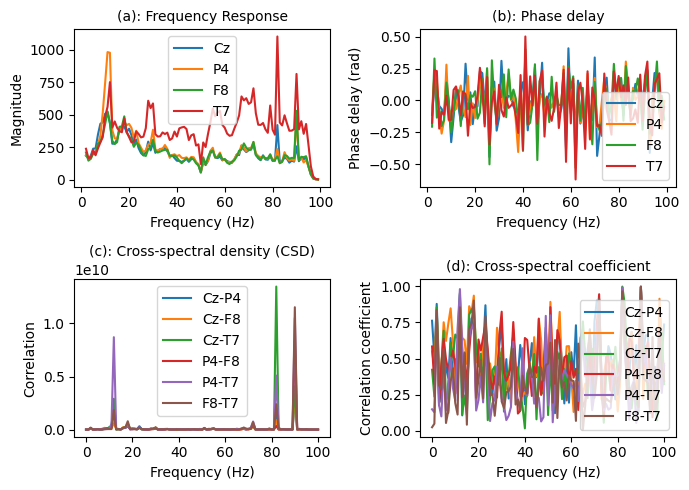

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

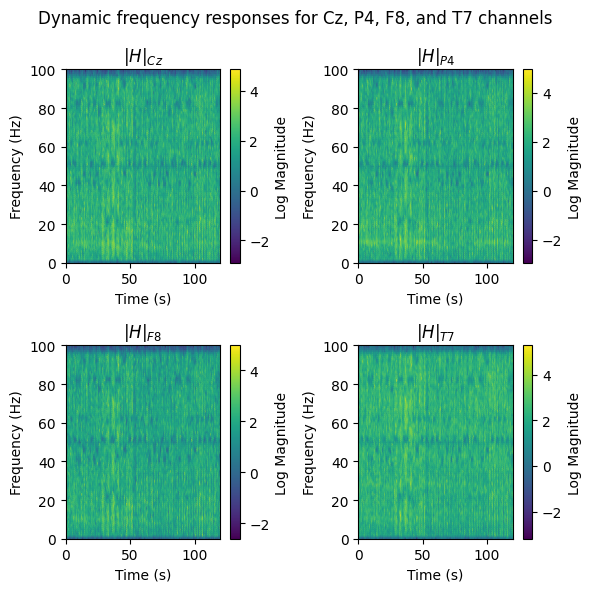

<ipython-input-15-b6316d2139e8>:208: RuntimeWarning: divide by zero encountered in divide
  ind_delay[var_name]=results[channel]['time_avg_propagation_delay']*1000/(2.0 * np.pi *f)


'\n  fig_write_path=fig_file+\'ind_channel_delay_file/\'+f"CD_S{subject}_ex{ex}.png"\n  plot_variables(\n        x=f,\n        y_vars=[delay_Cz,delay_P4, delay_F8, delay_T7],\n        x_unit=\'Frequency (Hz) \',\n        y_units=[\'ms\',\'ms\', \'ms\', \'ms\'],\n        legends=[\'Cz\', \'P4\', \'F8\', \'T7\'],\n        figure_file_name=fig_write_path,\n        x_tick_interval=5  # Adjust the interval for denser x-ticks\n    )\n'

In [ ]:
#import control
#from PyDynamic.model_estimation.fit_filter import LSIIR
import json
import pandas as pd
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
fig_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/Figures_AEP/'

comb_info_dict=[]

#Native_experience_Number = [5,8]
Native_experience_Number = 5
#Non_native_experience_Number = [6,9]
#ipdb.set_trace()
for subject in range(4,5):
#for subject in (1,2,3,4,6,8,9,10,11,12,13,14,15): #5, 7 defected
  subject_number = subject
  #print(subject_number)
  if subject < 10:
    subject = f'0{subject}'
  ex=Native_experience_Number
  sound_start_time = sound_trim[f'{subject}s'][ex-5]
  sound_end_time = sound_trim[f'{subject}e'][ex-5]
  sound_time = [sound_start_time,sound_end_time]
  ex = f'0{ex}'
  EEG_Signal_path = EEG_file_path+ f"/s{subject}_ex{ex}.csv"
  csv_write_path=output_file+f"Result_s{subject}_ex{ex}.csv"
  img_write_path=output_file+"Figures/"+f"Result_s{subject}_ex{ex}.png"
        #song_language_determing(subject_number, True)
        #print("calling")
  Langu = song_language_determing(subject_number, True)
  aud_SR, y_clip, aud_t_clip = aud_read(Langu)

        #aud_SR, t, y = aud_read(Full_Path)
        #return sr, y_clip, aud_t_clip


  #EEGtime, P4, Cz, F8,T7
  EEGtime, P4_raw, Cz_raw, F8_raw,T7_raw= EEG_read(EEG_Signal_path) # Read the four channel EEG signals
  EEGtime_start= 0 #set the EEG capturing time to 0 second and EEG time track will be utilized in further calculation
  EEGtime_end= EEGtime[np.size(EEGtime)-1]-EEGtime[0]  # End time of EEG capturing
  EEGtime=EEGtime-EEGtime[0] #change the starting time of EEG signal to 0 second
  Fs_EEG=np.round(1/(EEGtime[1]-EEGtime[0]))
#def custom_envelope(speech_sig, fs=None, f_min=1, f_max=100, env_fs=200):
# return envelope_decimated, t

  speech_env=sound2env(aud_SR,y_clip)
  speech_env=speech_env/np.max(speech_env)
  y_clip=y_clip/np.max(y_clip)


        #############Resampling the sound signal according to the sampling frequency of the EEG signal
  forcast = interpolate.interp1d(aud_t_clip, speech_env)
  speech_env_RS= forcast(EEGtime)  # y_RS is the resampled sound signal variable


  #######Notch filter to remove 50 Hz power frequency##############
  # Apply bandpass filter
   # filtered_signal = bandpass_filter(signal, lowcut, highcut, Fs_EEG)
  Cz = bandpass_filter(notch_filter(Cz_raw, Fs_EEG), 1, 95, Fs_EEG)
  P4 = bandpass_filter(notch_filter(P4_raw, Fs_EEG), 1, 95, Fs_EEG)
  F8 = bandpass_filter(notch_filter(F8_raw, Fs_EEG), 1, 95, Fs_EEG)
  T7 = bandpass_filter(notch_filter(T7_raw, Fs_EEG), 1, 95, Fs_EEG)
  #Cz = notch_filter(Cz_raw, Fs_EEG)
  #P4 = notch_filter(P4_raw, Fs_EEG)
  #F8 = notch_filter(F8_raw, Fs_EEG)
  #T7 = notch_filter(T7_raw, Fs_EEG)

  """
  ENV_EEGs_fig_write_path=fig_file+f"ENV_EEGs_S{subject}_ex{ex}.png"

  fig, axs = plt.subplots(5, 1, figsize=(7, 7))
  axs[0].plot(EEGtime, speech_env_RS, color='k')
  axs[0].set_xlabel('Time(s)')
  axs[0].set_ylabel('ENV')
  axs[0].grid(True)
  axs[1].plot(EEGtime, Cz, color='k')
  axs[1].set_xlabel('Time(s)')
  axs[1].set_ylabel('Cz('r'$\mu V)$')
  axs[1].grid(True)
  axs[2].plot(EEGtime, P4, color='k')
  axs[2].set_xlabel('Time(s)')
  axs[2].set_ylabel('P4 ('r'$\mu V)$')
  axs[2].grid(True)
  axs[3].plot(EEGtime, F8, color='k')
  axs[3].set_xlabel('Time(s)')
  axs[3].set_ylabel('F8 ('r'$\mu V)$')
  axs[3].grid(True)
  axs[4].plot(EEGtime, T7, color='k')
  axs[4].set_xlabel('Time(s)')
  axs[4].set_ylabel('T7 ('r'$\mu V)$')
  axs[4].grid(True)
  fig.tight_layout()
  fig.savefig(ENV_EEGs_fig_write_path, bbox_inches='tight', dpi = 200)
  plt.close()
  files.download(ENV_EEGs_fig_write_path)
  """


 # plt.show()


  # List of output channels and their names
  output_channels = [Cz, P4, F8, T7]
#channel_names = ['Cz', 'P4', 'F8', 'T7']
  comb_fig_write_path=fig_file+'Comb_figures/'+f'comb_fig_S{subject}_ex{ex}.png'
  # Example usage
  fs = Fs_EEG  # Example sampling frequency
  nperseg = 200
  noverlap = 100

  input_signal = speech_env_RS
  output_signals = output_channels

  results = compute_all(input_signal, output_signals, fs, nperseg, noverlap)
  f, t, _ = signal.stft(input_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
  plot_results(results, f, comb_fig_write_path)


    # Create a time and frequency meshgrid
  T, F = np.meshgrid(t, f)

  # Define the channels to plot
  channels = ['Cz', 'P4', 'F8', 'T7']
  Spectrum_fig_write_path=fig_file+'Spectrums/'+f"Spectrogram_S{subject}_ex{ex}.png"
  # Create subplots 'Comb_figures/'
  fig, axes = plt.subplots(2, 2, figsize=(6, 6))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Plot each channel's time-frequency transfer function
  for i, channel in enumerate(channels):
      H = results[channel]['transfer_function']
      ax = axes[i]
      #c = ax.pcolormesh(T, F, np.log10(np.abs(H))/np.max(np.log10(np.abs(H))), shading='gouraud')
      c = ax.pcolormesh(T, F, np.log10(np.abs(H)), shading='gouraud')
      ax.set_xlabel('Time (s)')
      ax.set_ylabel('Frequency (Hz)')
      #ax.set_title(f'Spectrogram for {channel}')
      ax.set_title(r'$|H|_{%s}$'% channel)
      fig.colorbar(c, ax=ax, label='Log Magnitude')
      #'$|H|_{(Cz)}$'
  # Adjust layout for better spacing
  #fig.suptitle('Dynamic frequency responses for Cz, P4, F8, and T7 channels', fontdict=font_dict)
  fig.suptitle('Dynamic frequency responses for Cz, P4, F8, and T7 channels')
  plt.tight_layout()
  plt.show()
  fig.savefig(Spectrum_fig_write_path, bbox_inches='tight', dpi = 200)
  #files.download(Spectrum_fig_write_path)
  plt.close()



  #output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
  Tf_write_path=output_file+'Tf_file/'+f'FR_S{subject}_ex{ex}.csv'
  # Create an empty dictionary to store the data
  Tf_dict = {'Frequency (Hz)': f}

  Tf_peak={}
  fixed_char = 'Tf_'
  for channel in ['Cz', 'P4', 'F8', 'T7']:
    Tf_dict[channel] = results[channel]['time_avg_frequency_response']
    var_name = fixed_char+channel
    Tf_array=np.log10(results[channel]['time_avg_frequency_response'])
    Tf_peak[var_name]=estimate_peak(f,Tf_array, height=0.5*np.max( Tf_array))['Peaks_pos']

  # Create a pandas DataFrame from the dictionary
  df = pd.DataFrame(Tf_dict)
  # Save the DataFrame to a CSV file
  df.to_csv(Tf_write_path, index=False)
  del Tf_write_path
  #f, results[f'{ch1}_{ch2}']['cross_correlation']
  #('Cz', 'P4'), ('Cz', 'F8'), ('Cz', 'T7'), ('P4', 'F8'), ('P4', 'T7'), ('F8', 'T7')
  H1H2_peak={}
  coh_peak={}
  rel_delay={}
  rel_delay['Frequency']=f
  # Fixed character to append
  fixed_char = "Cxy_"
  combinations = [('Cz', 'P4'), ('Cz', 'F8'), ('Cz', 'T7'), ('P4', 'F8'), ('P4', 'T7'), ('F8', 'T7')]
  for (ch1, ch2) in combinations:
    var_name = fixed_char+f'{ch1}_{ch2}'
    #'cross_corr_coeff'
    coh_array=results[f'{ch1}_{ch2}']['cross_corr_coeff']
    H1H2_array=np.log10(results[f'{ch1}_{ch2}']['cross_correlation'])
    coh_peak[var_name]=estimate_peak(f, coh_array, height=0.4*np.max( coh_array))['Peaks_pos']
    H1H2_peak[var_name]=estimate_peak(f, H1H2_array, height=0.4*np.max( H1H2_array))['Peaks_pos']
    rel_delay[var_name]=results[f'{ch1}_{ch2}']['relative_delay_difference']*1000/(2.0 * np.pi *f[i])


  rel_write_path=output_file+'relative_delay/'+f'rel_delay_S{subject}_ex{ex}.csv'
 #write_dict_to_csv(rel_delay, rel_write_path)
  df_rel_delay=pd.DataFrame(rel_delay)
  df_rel_delay.to_csv(rel_write_path, index=False)
  del rel_write_path

  ind_delay={}
  ind_delay['Frequency']=f
  fixed_char = 'D_'

  for channel in ['Cz', 'P4', 'F8', 'T7']:
    var_name = fixed_char+channel
    ind_delay[var_name]=results[channel]['time_avg_propagation_delay']*1000/(2.0 * np.pi *f)

  del_write_path=output_file+'ind_delay/'+f'del_S{subject}_ex{ex}.csv'
  #write_dict_to_csv(ind_delay, del_write_path)
  df_ind_delay=pd.DataFrame(ind_delay)
  df_ind_delay.to_csv(del_write_path, index=False)
  del del_write_path

  summ_variable={'Tf_peak':Tf_peak, 'Tf_H1H2': H1H2_peak,'Tf_coh_peak':coh_peak }
  comb_info_dict.append(summ_variable)

  """
  dfTfph = pd.DataFrame({'Frequency (Hz)' : f[0:90],
                      '$|H|_{Cz}$' : np.angle(Cz_spec[0:90]),
                      '$|H|_{P4}$': np.angle(P4_spec[0:90]),
                      '$|H|_{F8}$': np.angle(F8_spec[0:90]),
                      '$|H|_{T7}$': np.angle(T7_spec[0:90])})

    dfTfph.to_csv(Tfph_write_path, index=False)
  """
  #del rel_write_path


  """
  ENV_EEGs_fig_write_path=fig_file+'ENV_EEG_file/'+f"ENV_EEGs_S{subject}_ex{ex}.png"
  plot_variables(
      x=EEGtime,
      y_vars=[speech_env_RS, Cz, P4, F8, T7],
      x_unit='Time (s) ',
      y_units=['arb. unit','$\mu V)$', '$\mu V)$', '$\mu V)$', '$\mu V)$'],
      legends=['ENV', 'Cz', 'P4', 'F8', 'T7'],
      figure_file_name=ENV_EEGs_fig_write_path
  )
  #if unit or legend are not necessary then use ''
"""
"""
  # Compute transfer functions
  f, H_P4 = compute_transfer_function(speech_env_RS, P4, Fs_EEG)
  f, H_Cz = compute_transfer_function(speech_env_RS, Cz, Fs_EEG)
  f, H_F8 = compute_transfer_function(speech_env_RS, F8, Fs_EEG)
  f, H_T7 = compute_transfer_function(speech_env_RS, T7, Fs_EEG)
"""
"""
  Tf_fig_write_path=fig_file+'Tf_fig_file/'+f"Tf_S{subject}_ex{ex}.png"
  plot_variables(
        x=f,
        y_vars=[np.abs(H_Cz),np.abs(H_P4), np.abs(H_F8), np.abs(H_T7)],
        x_unit='Frequency (Hz) ',
        y_units=['$|H|_{(Cz)}$','$|H|_{(P4)}$', '$|H|_{(F8)}$', '$|H|_{(T7)}$'],
        legends=['Cz', 'P4', 'F8', 'T7'],
        figure_file_name=Tf_fig_write_path
        x_tick_interval=5  # Adjust the interval for denser x-ticks
    )
"""
"""
      # Compute propagation times
  delay_P4 = compute_propagation_time(H_P4, f)
  delay_Cz = compute_propagation_time(H_Cz, f)
  delay_F8 = compute_propagation_time(H_F8, f)
  delay_T7 = compute_propagation_time(H_T7, f)
"""
"""
  fig_write_path=fig_file+'ind_channel_delay_file/'+f"CD_S{subject}_ex{ex}.png"
  plot_variables(
        x=f,
        y_vars=[delay_Cz,delay_P4, delay_F8, delay_T7],
        x_unit='Frequency (Hz) ',
        y_units=['ms','ms', 'ms', 'ms'],
        legends=['Cz', 'P4', 'F8', 'T7'],
        figure_file_name=fig_write_path,
        x_tick_interval=5  # Adjust the interval for denser x-ticks
    )
"""

In [ ]:
# Saving results[channel]['time_avg_frequency_response'] for channel=['Cz', 'P4', 'F8', 'T7'] with respect to f in a csv file

import pandas as pd

# Create an empty dictionary to store the data
data_dict = {'Frequency': f}

# Loop through the channels and append their time_avg_frequency_response data
for channel in ['Cz', 'P4', 'F8', 'T7']:
    data_dict[channel] = results[channel]['time_avg_frequency_response']

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Save the DataFrame to a CSV file
csv_filename = 'frequency_response_data.csv'
df.to_csv(csv_filename, index=False)

print(f"Data saved to {csv_filename}")

In [ ]:
for i, channel in enumerate(channels):
  H = results[channel]['transfer_function']
  #print(np.log10(np.abs(H)))
  # Calculate the mean and standard deviation of log10(abs(H)) for each channel.
  mean_log10_H = np.mean((np.abs(H)))
  std_log10_H = np.std((np.abs(H)))
  excel_file_name = f"/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/Excel_files/Absolute_H_{channel}.xlsx"
  df_H = pd.DataFrame(np.log10(np.abs(H)))
  df_H.to_excel(excel_file_name, index=False)

  print(f"The mean log10 magnitude of the transfer function for {channel} is {mean_log10_H:.2f}, with a standard deviation of {std_log10_H:.2f}.")

# Someone can also calculate other descriptive statistics or perform statistical tests to further characterize the time-frequency transfer function for each channel.

The mean log10 magnitude of the transfer function for Cz is 202.63, with a standard deviation of 716.27.
The mean log10 magnitude of the transfer function for P4 is 226.50, with a standard deviation of 995.80.
The mean log10 magnitude of the transfer function for F8 is 201.81, with a standard deviation of 797.62.
The mean log10 magnitude of the transfer function for T7 is 382.82, with a standard deviation of 1776.15.


In [ ]:
import json
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
json_write_file=output_file+"comb_summ_info.json"
with open(json_write_file, "w") as f:
  json.dump(comb_info_dict, f)

In [ ]:
import json
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
json_read_file=output_file+"comb_summ_info.json"
with open(json_read_file, "r") as fr:
    loaded_dict = json.load(fr)
print(loaded_dict)

[{'Tf_peak': {'Tf_Cz': [10.0, 22.0, 32.0, 46.0, 61.0, 76.0, 88.0], 'Tf_P4': [11.0, 32.0, 47.0, 61.0, 76.0, 89.0], 'Tf_F8': [5.0, 16.0, 27.0, 41.0, 55.0, 67.0, 80.0, 92.0], 'Tf_T7': [16.0, 32.0, 47.0, 62.0, 76.0, 86.0]}, 'Tf_H1H2': {'Cxy_Cz_P4': [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 88.0], 'Cxy_Cz_F8': [5.0, 16.0, 27.0, 43.0, 57.0, 67.0, 88.0], 'Cxy_Cz_T7': [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 86.0, 96.0], 'Cxy_P4_F8': [5.0, 16.0, 27.0, 43.0, 55.0, 67.0, 88.0], 'Cxy_P4_T7': [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 86.0], 'Cxy_F8_T7': [5.0, 16.0, 27.0, 40.0, 57.0, 67.0, 86.0, 97.0]}, 'Tf_coh_peak': {'Cxy_Cz_P4': [5.0, 16.0, 27.0, 37.0, 49.0, 61.0, 75.0, 88.0], 'Cxy_Cz_F8': [5.0, 16.0, 27.0, 44.0, 55.0, 65.0, 75.0, 86.0, 97.0], 'Cxy_Cz_T7': [5.0, 16.0, 27.0, 39.0, 50.0, 61.0, 75.0, 86.0, 97.0], 'Cxy_P4_F8': [5.0, 16.0, 27.0, 46.0, 57.0, 67.0, 86.0, 97.0], 'Cxy_P4_T7': [6.0, 16.0, 27.0, 37.0, 50.0, 61.0, 75.0, 86.0, 97.0], 'Cxy_F8_T7': [5.0, 16.0, 27.0, 40.0, 55.0, 67.0, 86.0, 97.0]}}, {'Tf_peak':

In [ ]:
# Creating a latex table  having 5 columns: subject, 'Tf_peak': 'Tf_Cz',  'Tf_peak': 'Tf_P4' ,  'Tf_peak': 'Tf_F8', and  'Tf_peak': 'Tf_T7' from the  loaded_dict dictionary

import pandas as pd
from tabulate import tabulate

# Extract relevant data from the loaded dictionary
subjects = list(range(1, len(loaded_dict) + 1))
Tf_Cz_peaks = [d['Tf_peak']['Tf_Cz'] for d in loaded_dict]
Tf_P4_peaks = [d['Tf_peak']['Tf_P4'] for d in loaded_dict]
Tf_F8_peaks = [d['Tf_peak']['Tf_F8'] for d in loaded_dict]
Tf_T7_peaks = [d['Tf_peak']['Tf_T7'] for d in loaded_dict]

# Create a Pandas DataFrame
df = pd.DataFrame({
    'subject': subjects,
    'Tf_peak: Tf_Cz': Tf_Cz_peaks,
    'Tf_peak: Tf_P4': Tf_P4_peaks,
    'Tf_peak: Tf_F8': Tf_F8_peaks,
    'Tf_peak: Tf_T7': Tf_T7_peaks
})

# Convert DataFrame to LaTeX tabular format
latex_table = tabulate(df, headers='keys', tablefmt="latex")

# Print the LaTeX table
print(latex_table)


\begin{tabular}{rrllll}
\hline
    &   subject & Tf\_peak: Tf\_Cz                                   & Tf\_peak: Tf\_P4                                   & Tf\_peak: Tf\_F8                                   & Tf\_peak: Tf\_T7                                  \\
\hline
  0 &         1 & [10.0, 22.0, 32.0, 46.0, 61.0, 76.0, 88.0]       & [11.0, 32.0, 47.0, 61.0, 76.0, 89.0]             & [5.0, 16.0, 27.0, 41.0, 55.0, 67.0, 80.0, 92.0]  & [16.0, 32.0, 47.0, 62.0, 76.0, 86.0]            \\
  1 &         2 & [10.0, 27.0, 37.0, 52.0, 62.0, 72.0, 84.0]       & [10.0, 22.0, 32.0, 47.0, 61.0, 72.0, 84.0]       & [10.0, 27.0, 37.0, 47.0, 62.0, 76.0, 92.0]       & [10.0, 27.0, 37.0, 47.0, 64.0, 76.0, 92.0]      \\
  2 &         3 & [3.0, 17.0, 30.0, 42.0, 54.0, 69.0, 82.0, 94.0]  & [2.0, 17.0, 30.0, 41.0, 55.0, 67.0, 82.0, 92.0]  & [2.0, 16.0, 30.0, 47.0, 57.0, 68.0, 80.0, 90.0]  & [12.0, 30.0, 43.0, 55.0, 67.0, 80.0, 90.0]      \\
  3 &         4 & [11.0, 23.0, 35.0, 55.0, 72.0, 82.0, 94.0]      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

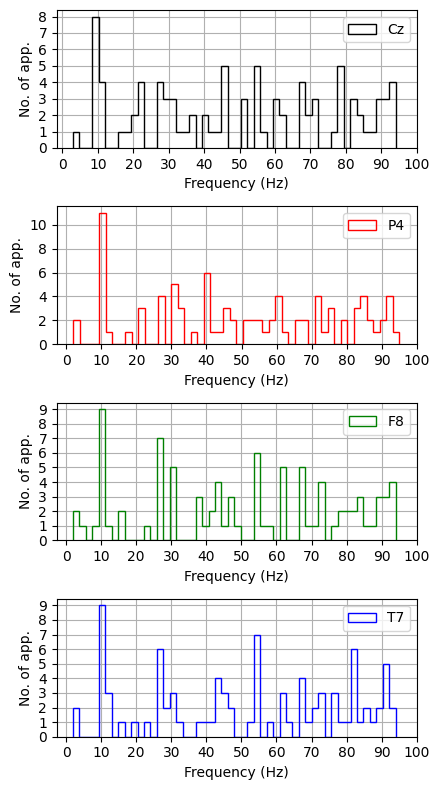

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from matplotlib.ticker import MaxNLocator
#output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
fig_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/Figures_AEP/'

Tf_table_list=[]
Tf_hist_list_Cz=[]
Tf_hist_list_P4=[]
Tf_hist_list_F8=[]
Tf_hist_list_T7=[]

for subject in range(0,13):
  Tf_hist_list_Cz.extend(loaded_dict[subject]['Tf_peak']['Tf_Cz'])
  Tf_hist_list_P4.extend(loaded_dict[subject]['Tf_peak']['Tf_P4'])
  Tf_hist_list_F8.extend(loaded_dict[subject]['Tf_peak']['Tf_F8'])
  Tf_hist_list_T7.extend(loaded_dict[subject]['Tf_peak']['Tf_T7'])

  Tf_table_list.append({'Subject': subject,
                        'Cz':loaded_dict[subject]['Tf_peak']['Tf_Cz'],
                        'P4':loaded_dict[subject]['Tf_peak']['Tf_P4'],
                        'F8':loaded_dict[subject]['Tf_peak']['Tf_F8'],
                        'T7':loaded_dict[subject]['Tf_peak']['Tf_T7']
                         })

abs_TfHist_fig_write_path=fig_file+"abs_Tf_hist.png"
fig, axs = plt.subplots(4, 1, figsize=(4.5, 8))
axs[0].hist(Tf_hist_list_Cz,histtype='step', bins=50, color='k', label='Cz')
axs[0].set_xticks(np.arange(0, 105, 10))
axs[0].set_xlabel('Frequency (Hz)')
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_ylabel('No. of app.')
axs[0].grid(True)
axs[0].legend()
axs[1].hist(Tf_hist_list_P4,histtype='step', bins=50, color='r', label='P4')  # Use histtype='step'
axs[1].set_xticks(np.arange(0, 105, 10))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].set_ylabel('No. of app.')
axs[1].grid(True)
axs[1].legend()
axs[2].hist(Tf_hist_list_F8,histtype='step', bins=50, color='g', label='F8')  # Use histtype='step'
axs[2].set_xticks(np.arange(0, 105, 10))
axs[2].set_xlabel('Frequency (Hz)')
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].set_ylabel('No. of app.')
axs[2].grid(True)
axs[2].legend()
axs[3].hist(Tf_hist_list_T7,histtype='step', bins=50, color='b', label='T7')  # Use histtype='step'
axs[3].set_xticks(np.arange(0, 105, 10))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[3].set_ylabel('No. of app.')
axs[3].grid(True)
axs[3].legend()

fig.tight_layout()
fig.savefig(abs_TfHist_fig_write_path, bbox_inches='tight', dpi = 200)
files.download(abs_TfHist_fig_write_path)
plt.show()

In [ ]:
print(Tf_hist_list_P4)

[11.0, 32.0, 47.0, 61.0, 76.0, 89.0, 10.0, 22.0, 32.0, 47.0, 61.0, 72.0, 84.0, 2.0, 17.0, 30.0, 41.0, 55.0, 67.0, 82.0, 92.0, 11.0, 30.0, 41.0, 55.0, 72.0, 90.0, 2.0, 12.0, 30.0, 41.0, 54.0, 72.0, 82.0, 92.0, 11.0, 21.0, 32.0, 42.0, 61.0, 71.0, 84.0, 10.0, 30.0, 44.0, 58.0, 68.0, 79.0, 90.0, 10.0, 27.0, 45.0, 61.0, 76.0, 86.0, 10.0, 30.0, 41.0, 54.0, 67.0, 82.0, 92.0, 11.0, 27.0, 40.0, 52.0, 62.0, 76.0, 86.0, 10.0, 27.0, 41.0, 52.0, 68.0, 84.0, 11.0, 22.0, 36.0, 46.0, 56.0, 73.0, 84.0, 95.0, 10.0, 27.0, 45.0, 59.0, 79.0, 92.0]


In [ ]:
counts, bin_edges = np.histogram(Tf_hist_list_Cz, bins=50)
print("Array of band edges:", bin_edges)
counts, bin_edges = np.histogram(Tf_hist_list_P4, bins=50)
print("Array of band edges:", bin_edges)
counts, bin_edges = np.histogram(Tf_hist_list_F8, bins=50)
print("Array of band edges:", bin_edges)
counts, bin_edges = np.histogram(Tf_hist_list_T7, bins=50)
print("Array of band edges:", bin_edges)

Array of band edges: [ 3.    4.82  6.64  8.46 10.28 12.1  13.92 15.74 17.56 19.38 21.2  23.02
 24.84 26.66 28.48 30.3  32.12 33.94 35.76 37.58 39.4  41.22 43.04 44.86
 46.68 48.5  50.32 52.14 53.96 55.78 57.6  59.42 61.24 63.06 64.88 66.7
 68.52 70.34 72.16 73.98 75.8  77.62 79.44 81.26 83.08 84.9  86.72 88.54
 90.36 92.18 94.  ]
Array of band edges: [ 2.    3.86  5.72  7.58  9.44 11.3  13.16 15.02 16.88 18.74 20.6  22.46
 24.32 26.18 28.04 29.9  31.76 33.62 35.48 37.34 39.2  41.06 42.92 44.78
 46.64 48.5  50.36 52.22 54.08 55.94 57.8  59.66 61.52 63.38 65.24 67.1
 68.96 70.82 72.68 74.54 76.4  78.26 80.12 81.98 83.84 85.7  87.56 89.42
 91.28 93.14 95.  ]
Array of band edges: [ 2.    3.84  5.68  7.52  9.36 11.2  13.04 14.88 16.72 18.56 20.4  22.24
 24.08 25.92 27.76 29.6  31.44 33.28 35.12 36.96 38.8  40.64 42.48 44.32
 46.16 48.   49.84 51.68 53.52 55.36 57.2  59.04 60.88 62.72 64.56 66.4
 68.24 70.08 71.92 73.76 75.6  77.44 79.28 81.12 82.96 84.8  86.64 88.48
 90.32 92.16 94.  ]
Arra

In [ ]:
import pandas as pd
import numpy as np
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
Native_experience_Number = 5
ex = f'0{Native_experience_Number}'
subject=0
delay_2Dlist_Cz=[]
delay_2Dlist_P4=[]
delay_2Dlist_F8=[]
delay_2Dlist_T7=[]

subject=0
#for csv_subject in range(1,3):
#for subject in range(0,13):

for csv_subject in (1,2,3,4,6,8,9,10,11,12,13,14,15): #5, 7 defected
  if csv_subject < 10:
    csv_subject = f'0{csv_subject}'
  indv_prop_delay_read_path=output_file+'ind_delay/'+f'del_S{csv_subject}_ex{ex}.csv'
  df = pd.read_csv(indv_prop_delay_read_path)
  #{'Tf_peak': {'Tf_Cz':
  vector_Cz=np.zeros(len(df[df.columns[1]]))
  index_Cz=[int(x-1) for x in (loaded_dict[subject]['Tf_peak']['Tf_Cz'])]
  vector_Cz[index_Cz]=1 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
  delay_2Dlist_Cz.append(freq_delay_Cz)

  vector_P4=np.zeros(len(df[df.columns[2]]))
  index_P4=[int(x-1) for x in (loaded_dict[subject]['Tf_peak']['Tf_P4'])]
  vector_P4[index_P4]=1 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_P4 = [a * b for a, b in zip(vector_P4, df[df.columns[2]])]
  delay_2Dlist_P4.append(freq_delay_P4)

  vector_F8=np.zeros(len(df[df.columns[3]]))
  index_F8=[int(x-1) for x in (loaded_dict[subject]['Tf_peak']['Tf_F8'])]
  vector_F8[index_F8]=1 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_F8 = [a * b for a, b in zip(vector_F8, df[df.columns[3]])]
  delay_2Dlist_F8.append(freq_delay_F8)

  vector_T7=np.zeros(len(df[df.columns[4]]))
  index_T7=[int(x-1) for x in (loaded_dict[subject]['Tf_peak']['Tf_T7'])]
  vector_T7[index_T7]=1 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_T7 = [a * b for a, b in zip(vector_T7, df[df.columns[4]])]
  delay_2Dlist_T7.append(freq_delay_T7)

  subject=subject+1

delay_freq_time_estimation(delay_2Dlist_Cz)
delay_freq_time_estimation(delay_2Dlist_P4)
delay_freq_time_estimation(delay_2Dlist_F8)
delay_freq_time_estimation(delay_2Dlist_T7)

<ipython-input-7-c75e25b57ad4>:26: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
<ipython-input-7-c75e25b57ad4>:33: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_P4 = [a * b for a, b in zip(vector_P4, df[df.columns[2]])]
<ipython-input-7-c75e25b57ad4>:40: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_F8 = [a * b for a, b in zip(vector_F8, df[df.columns[3]])]
<ipython-input-7-c75e25b57ad4>:47: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_T7 = [a * b for a, b in zip(vector_T7, df[df.columns[4]])]
<ipython-input-7-c75e25b57ad4>:26: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
<ipython-input-7-c75e25b57ad4>:33: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_P4 = [a * b for a, b in zip(vector_P4, df[df.column

\begin{tabular}{rl}
\hline
   Frequency (Hz) & Time (ms)                                                         \\
\hline
                1 & [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] \\
                3 & [-23.1092]                                                        \\
                9 & [8.2761]                                                          \\
               10 & [-2.5994, -0.5938, -3.1321, 1.0927, 2.8389, -0.1735, 0.7736]      \\
               11 & [-5.2131, 1.2797, -2.1206]                                        \\
               12 & [0.0867]                                                          \\
               17 & [2.2883]                                                          \\
               19 & [-1.1077]                                                         \\
               21 & [1.6097, 2.9636]                                                  \\
               22 & [-1.5612]                                               

<ipython-input-7-c75e25b57ad4>:26: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
<ipython-input-7-c75e25b57ad4>:33: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_P4 = [a * b for a, b in zip(vector_P4, df[df.columns[2]])]
<ipython-input-7-c75e25b57ad4>:40: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_F8 = [a * b for a, b in zip(vector_F8, df[df.columns[3]])]
<ipython-input-7-c75e25b57ad4>:47: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_T7 = [a * b for a, b in zip(vector_T7, df[df.columns[4]])]


In [ ]:
import pandas as pd
import numpy as np
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
Native_experience_Number = 5
ex = f'0{Native_experience_Number}'
subject=0
delay_2Dlist_Cz=[]
delay_2Dlist_P4=[]
delay_2Dlist_F8=[]
delay_2Dlist_T7=[]

subject=0
#for csv_subject in range(1,3):
#for subject in range(0,13):

for csv_subject in (1,2): #5, 7 defected
  if csv_subject < 10:
    csv_subject = f'0{csv_subject}'
  indv_prop_delay_read_path=output_file+'ind_delay/'+f'del_S{csv_subject}_ex{ex}.csv'
  df = pd.read_csv(indv_prop_delay_read_path)
  #{'Tf_peak': {'Tf_Cz':
  vector_Cz=np.zeros(len(df[df.columns[1]]))

  index_Cz=[int(x-1) for x in (loaded_dict[subject]['Tf_peak']['Tf_Cz'])]
  #print(index_Cz)
  vector_Cz[index_Cz]=1 #For milisecond
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
  print(freq_delay_Cz)
  subject=subject+1



[nan, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -2.599435394382857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -1.5611629847462691, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.1493206421838296, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 1.355962675899813, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.3686614162987374, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.1060313890144854, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.1770523353805156, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[nan, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.5937669102086399, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.4687453942809927, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.9150708498167396, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.41994589567154

<ipython-input-22-aa8a4f9d30ec>:27: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]
<ipython-input-22-aa8a4f9d30ec>:27: RuntimeWarning: invalid value encountered in scalar multiply
  freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]


In [ ]:
# multiple element by element of the two vector_Cz and df[df.columns[1]

# Perform element-wise multiplication using zip() function
freq_delay_Cz = [a * b for a, b in zip(vector_Cz, df[df.columns[1]])]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

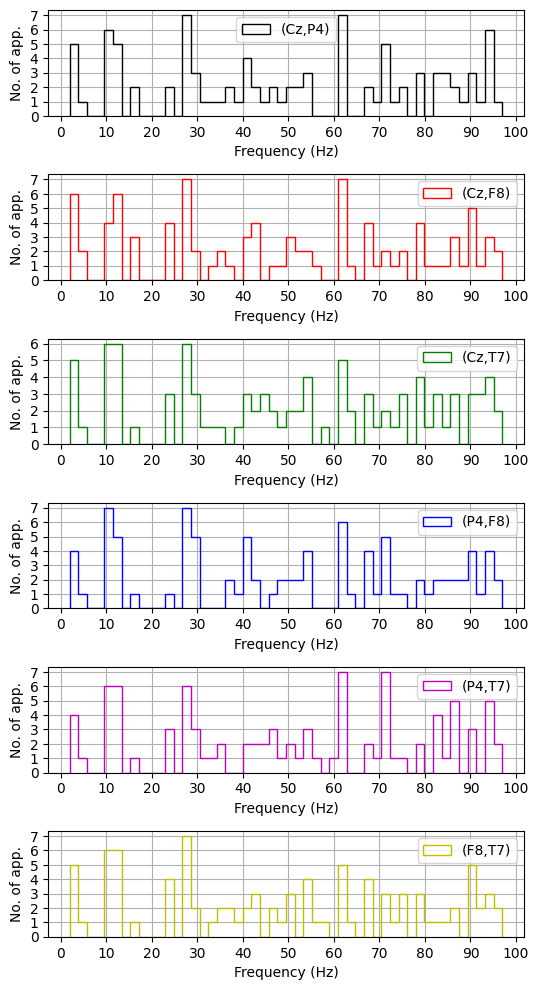

\begin{tabular}{rllllll}
\hline
   Subject & (Cz,P4)                                               & (Cz,F8)                                               & (Cz,T7)                                          & (P4,F8)                                          & (P4,T7)                                          & (F8,T7)                                         \\
\hline
         0 & [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 88.0]             & [5.0, 16.0, 27.0, 43.0, 57.0, 67.0, 88.0]             & [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 86.0, 96.0]  & [5.0, 16.0, 27.0, 43.0, 55.0, 67.0, 88.0]        & [5.0, 16.0, 32.0, 43.0, 61.0, 75.0, 86.0]        & [5.0, 16.0, 27.0, 40.0, 57.0, 67.0, 86.0, 97.0] \\
         1 & [3.0, 16.0, 27.0, 37.0, 47.0, 61.0, 72.0, 84.0, 94.0] & [3.0, 13.0, 27.0, 47.0, 64.0, 75.0, 86.0, 97.0]       & [10.0, 27.0, 41.0, 52.0, 64.0, 76.0, 92.0]       & [10.0, 27.0, 47.0, 61.0, 72.0, 84.0, 95.0]       & [3.0, 13.0, 27.0, 47.0, 61.0, 72.0, 84.0, 94.0]  & [3.0, 13.0, 27.0, 37.0, 5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
fig_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/Figures_AEP/'
#'Tf_coh_peak': {'Cxy_Cz_P4':
TfH1H2_table_list=[]
TfH1H2_hist_list_Cz_P4=[]
TfH1H2_hist_list_Cz_F8=[]
TfH1H2_hist_list_Cz_T7=[]
TfH1H2_hist_list_P4_F8=[]
TfH1H2_hist_list_P4_T7=[]
TfH1H2_hist_list_F8_T7=[]
#summ_variable={'Tf_peak':Tf_peak, 'Tf_H1H2': H1H2_peak,'Tf_coh_peak':coh_peak }
for subject in range(0,13):
  TfH1H2_hist_list_Cz_P4.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_P4'])
  TfH1H2_hist_list_Cz_F8.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_F8'])
  TfH1H2_hist_list_Cz_T7.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_T7'])
  TfH1H2_hist_list_P4_F8.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_P4_F8'])
  TfH1H2_hist_list_P4_T7.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_P4_T7'])
  TfH1H2_hist_list_F8_T7.extend(loaded_dict[subject]['Tf_H1H2']['Cxy_F8_T7'])
  TfH1H2_table_list.append({'Subject': subject,
                        '(Cz,P4)':loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_P4'],
                        '(Cz,F8)':loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_F8'],
                        '(Cz,T7)':loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_T7'],
                        '(P4,F8)':loaded_dict[subject]['Tf_H1H2']['Cxy_P4_F8'],
                        '(P4,T7)':loaded_dict[subject]['Tf_H1H2']['Cxy_P4_T7'],
                        '(F8,T7)':loaded_dict[subject]['Tf_H1H2']['Cxy_F8_T7']
                         })

TfH1H2Hist_fig_write_path=fig_file+"TfH1H2_hist.png"
#fig, axs = plt.subplots(6, 1, figsize=(4.5, 10))
fig, axs = plt.subplots(6, 1, figsize=(5.5, 10))
axs[0].hist(TfH1H2_hist_list_Cz_P4,histtype='step', bins=50, color='k', label='(Cz,P4)')
#axs[0].hist(TfCr_hist_list_Cz_P4,histtype='step', bins=45, color='k', label='(Cz,P4)')
axs[0].set_xticks(np.arange(0, 105, 10))
axs[0].set_xlabel('Frequency (Hz)')
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].set_ylabel('No. of app.')
axs[0].grid(True)
axs[0].legend()
axs[1].hist(TfH1H2_hist_list_Cz_F8,histtype='step', bins=50, color='r', label='(Cz,F8)')  # Use histtype='step'
axs[1].set_xticks(np.arange(0, 105, 10))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].set_ylabel('No. of app.')
axs[1].grid(True)
axs[1].legend()
axs[2].hist(TfH1H2_hist_list_Cz_T7,histtype='step', bins=50, color='g', label='(Cz,T7)')  # Use histtype='step'
axs[2].set_xticks(np.arange(0, 105, 10))
axs[2].set_xlabel('Frequency (Hz)')
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[2].set_ylabel('No. of app.')
axs[2].grid(True)
axs[2].legend()
axs[3].hist(TfH1H2_hist_list_P4_F8,histtype='step', bins=50, color='b', label='(P4,F8)')  # Use histtype='step'
axs[3].set_xticks(np.arange(0, 105, 10))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[3].set_ylabel('No. of app.')
axs[3].grid(True)
axs[3].legend()
axs[4].hist(TfH1H2_hist_list_P4_T7,histtype='step', bins=50, color='m', label='(P4,T7)')  # Use histtype='step'
axs[4].set_xticks(np.arange(0, 105, 10))
axs[4].set_xlabel('Frequency (Hz)')
axs[4].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[4].set_ylabel('No. of app.')
axs[4].grid(True)
axs[4].legend()
axs[5].hist(TfH1H2_hist_list_F8_T7,histtype='step', bins=50, color='y', label='(F8,T7)')  # Use histtype='step'
axs[5].set_xticks(np.arange(0, 105, 10))
axs[5].set_xlabel('Frequency (Hz)')
axs[5].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[5].set_ylabel('No. of app.')
axs[5].grid(True)
axs[5].legend()
fig.tight_layout()
fig.savefig(TfH1H2Hist_fig_write_path, bbox_inches='tight', dpi = 200)
files.download(TfH1H2Hist_fig_write_path)
plt.show()

latex_table = tabulate(TfH1H2_table_list, headers='keys', tablefmt="latex")

print(latex_table)

In [ ]:
counts, bin_edges = np.histogram(TfH1H2_hist_list_Cz_P4, bins=50)
print("Array of band edges Cz_P4:", bin_edges)
counts, bin_edges = np.histogram(TfH1H2_hist_list_Cz_F8, bins=50)
print("Array of band edges Cz_F8:", bin_edges)
counts, bin_edges = np.histogram(TfH1H2_hist_list_Cz_T7, bins=50)
print("Array of band edges Cz_T7:", bin_edges)-
counts, bin_edges = np.histogram(TfH1H2_hist_list_P4_F8, bins=50)
print("Array of band edges P4_F8:", bin_edges)
counts, bin_edges = np.histogram(TfH1H2_hist_list_P4_T7, bins=50)
print("Array of band edges P4_T7:", bin_edges)
counts, bin_edges = np.histogram(TfH1H2_hist_list_F8_T7, bins=50)
print("Array of band edges F8_T7:", bin_edges)

Array of band edges Cz_P4: [ 2.   3.9  5.8  7.7  9.6 11.5 13.4 15.3 17.2 19.1 21.  22.9 24.8 26.7
 28.6 30.5 32.4 34.3 36.2 38.1 40.  41.9 43.8 45.7 47.6 49.5 51.4 53.3
 55.2 57.1 59.  60.9 62.8 64.7 66.6 68.5 70.4 72.3 74.2 76.1 78.  79.9
 81.8 83.7 85.6 87.5 89.4 91.3 93.2 95.1 97. ]
Array of band edges Cz_F8: [ 2.   3.9  5.8  7.7  9.6 11.5 13.4 15.3 17.2 19.1 21.  22.9 24.8 26.7
 28.6 30.5 32.4 34.3 36.2 38.1 40.  41.9 43.8 45.7 47.6 49.5 51.4 53.3
 55.2 57.1 59.  60.9 62.8 64.7 66.6 68.5 70.4 72.3 74.2 76.1 78.  79.9
 81.8 83.7 85.6 87.5 89.4 91.3 93.2 95.1 97. ]
Array of band edges Cz_T7: [ 2.   3.9  5.8  7.7  9.6 11.5 13.4 15.3 17.2 19.1 21.  22.9 24.8 26.7
 28.6 30.5 32.4 34.3 36.2 38.1 40.  41.9 43.8 45.7 47.6 49.5 51.4 53.3
 55.2 57.1 59.  60.9 62.8 64.7 66.6 68.5 70.4 72.3 74.2 76.1 78.  79.9
 81.8 83.7 85.6 87.5 89.4 91.3 93.2 95.1 97. ]
Array of band edges P4_F8: [ 2.   3.9  5.8  7.7  9.6 11.5 13.4 15.3 17.2 19.1 21.  22.9 24.8 26.7
 28.6 30.5 32.4 34.3 36.2 38.1 40.  41.9 

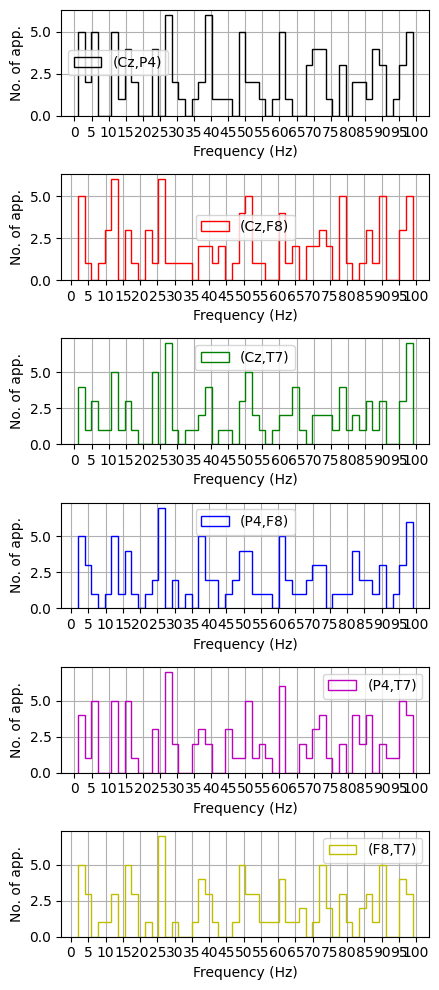

\begin{tabular}{rllllll}
\hline
   Subject & (Cz,P4)                                               & (Cz,F8)                                               & (Cz,T7)                                               & (P4,F8)                                               & (P4,T7)                                               & (F8,T7)                                               \\
\hline
         0 & [5.0, 16.0, 27.0, 37.0, 49.0, 61.0, 75.0, 88.0]       & [5.0, 16.0, 27.0, 44.0, 55.0, 65.0, 75.0, 86.0, 97.0] & [5.0, 16.0, 27.0, 39.0, 50.0, 61.0, 75.0, 86.0, 97.0] & [5.0, 16.0, 27.0, 46.0, 57.0, 67.0, 86.0, 97.0]       & [6.0, 16.0, 27.0, 37.0, 50.0, 61.0, 75.0, 86.0, 97.0] & [5.0, 16.0, 27.0, 40.0, 55.0, 67.0, 86.0, 97.0]       \\
         1 & [3.0, 13.0, 27.0, 46.0, 61.0, 72.0, 84.0, 98.0]       & [3.0, 13.0, 27.0, 47.0, 64.0, 75.0, 86.0, 98.0]       & [1.0, 13.0, 27.0, 43.0, 64.0, 75.0, 86.0, 98.0]       & [5.0, 16.0, 27.0, 47.0, 64.0, 84.0, 98.0]             & [1.0, 16.0, 27.0, 48.0, 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
fig_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/Figures_AEP/'
#'Tf_coh_peak': {'Cxy_Cz_P4':
TfCoh_table_list=[]
TfCoh_hist_list_Cz_P4=[]
TfCoh_hist_list_Cz_F8=[]
TfCoh_hist_list_Cz_T7=[]
TfCoh_hist_list_P4_F8=[]
TfCoh_hist_list_P4_T7=[]
TfCoh_hist_list_F8_T7=[]
#summ_variable={'Tf_peak':Tf_peak, 'Tf_H1H2': H1H2_peak,'Tf_coh_peak':coh_peak }
for subject in range(0,13):
  TfCoh_hist_list_Cz_P4.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_P4'])
  TfCoh_hist_list_Cz_F8.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_F8'])
  TfCoh_hist_list_Cz_T7.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_T7'])
  TfCoh_hist_list_P4_F8.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_P4_F8'])
  TfCoh_hist_list_P4_T7.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_P4_T7'])
  TfCoh_hist_list_F8_T7.extend(loaded_dict[subject]['Tf_coh_peak']['Cxy_F8_T7'])
  TfCoh_table_list.append({'Subject': subject,
                        '(Cz,P4)':loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_P4'],
                        '(Cz,F8)':loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_F8'],
                        '(Cz,T7)':loaded_dict[subject]['Tf_coh_peak']['Cxy_Cz_T7'],
                        '(P4,F8)':loaded_dict[subject]['Tf_coh_peak']['Cxy_P4_F8'],
                        '(P4,T7)':loaded_dict[subject]['Tf_coh_peak']['Cxy_P4_T7'],
                        '(F8,T7)':loaded_dict[subject]['Tf_coh_peak']['Cxy_F8_T7']
                         })

TfCohHist_fig_write_path=fig_file+"TfCoh_hist.png"
#fig, axs = plt.subplots(6, 1, figsize=(4.5, 10))
fig, axs = plt.subplots(6, 1, figsize=(4.5, 10))
axs[0].hist(TfCoh_hist_list_Cz_P4,histtype='step', bins=50, color='k', label='(Cz,P4)')
#axs[0].hist(TfCr_hist_list_Cz_P4,histtype='step', bins=45, color='k', label='(Cz,P4)')
axs[0].set_xticks(np.arange(0, 105, 5))
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('No. of app.')
axs[0].grid(True)
axs[0].legend()
axs[1].hist(TfCoh_hist_list_Cz_F8,histtype='step', bins=50, color='r', label='(Cz,F8)')  # Use histtype='step'
axs[1].set_xticks(np.arange(0, 105, 5))
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('No. of app.')
axs[1].grid(True)
axs[1].legend()
axs[2].hist(TfCoh_hist_list_Cz_T7,histtype='step', bins=50, color='g', label='(Cz,T7)')  # Use histtype='step'
axs[2].set_xticks(np.arange(0, 105, 5))
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_ylabel('No. of app.')
axs[2].grid(True)
axs[2].legend()
axs[3].hist(TfCoh_hist_list_P4_F8,histtype='step', bins=50, color='b', label='(P4,F8)')  # Use histtype='step'
axs[3].set_xticks(np.arange(0, 105, 5))
axs[3].set_xlabel('Frequency (Hz)')
axs[3].set_ylabel('No. of app.')
axs[3].grid(True)
axs[3].legend()
axs[4].hist(TfCoh_hist_list_P4_T7,histtype='step', bins=50, color='m', label='(P4,T7)')  # Use histtype='step'
axs[4].set_xticks(np.arange(0, 105, 5))
axs[4].set_xlabel('Frequency (Hz)')
axs[4].set_ylabel('No. of app.')
axs[4].grid(True)
axs[4].legend()
axs[5].hist(TfCoh_hist_list_F8_T7,histtype='step', bins=50, color='y', label='(F8,T7)')  # Use histtype='step'
axs[5].set_xticks(np.arange(0, 105, 5))
axs[5].set_xlabel('Frequency (Hz)')
axs[5].set_ylabel('No. of app.')
axs[5].grid(True)
axs[5].legend()
fig.tight_layout()
#fig.savefig(TfCohHist_fig_write_path, bbox_inches='tight', dpi = 200)
#files.download(TfCohHist_fig_write_path)
plt.show()

latex_table = tabulate(TfCoh_table_list, headers='keys', tablefmt="latex")

print(latex_table)

In [ ]:
import pandas as pd
import numpy as np
output_file='/content/drive/MyDrive/STUDY/Research_Mahbub/computational_Results/AEP_data/'
Native_experience_Number = 5
ex = f'0{Native_experience_Number}'
subject=0
delay_2Dlist_Cz_P4=[]
delay_2Dlist_Cz_F8=[]
delay_2Dlist_Cz_T7=[]
delay_2Dlist_P4_F8=[]
delay_2Dlist_P4_T7=[]
delay_2Dlist_F8_T7=[]
#for csv_subject in range(1,3):
for csv_subject in (1,2,3,4,6,8,9,10,11,12,13,14,15): #5, 7 defected
  if csv_subject < 10:
    csv_subject = f'0{csv_subject}'
  ch_prop_delay_read_path=output_file+'relative_delay/'+f'rel_delay_S{csv_subject}_ex{ex}.csv'
  df = pd.read_csv(ch_prop_delay_read_path)
  #output_file+'relative_delay/'+f'rel_delay_S{csv_subject}_ex{ex}.csv'
  #indv_prop_delay_read_path=output_file+'ind_delay/'+f'del_S{csv_subject}_ex{ex}.csv'
  vector_Cz_P4=np.zeros(len(df[df.columns[1]]))
  index_Cz_P4=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_P4'])]
  vector_Cz_P4[index_Cz_P4]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_Cz_P4 = [a * b for a, b in zip(vector_Cz_P4, df[df.columns[1]])]
  delay_2Dlist_Cz_P4.append(freq_delay_Cz_P4)

  vector_Cz_F8=np.zeros(len(df[df.columns[2]]))
  index_Cz_F8=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_F8'])]
  vector_Cz_F8[index_Cz_F8]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_Cz_F8 = [a * b for a, b in zip(vector_Cz_F8, df[df.columns[2]])]
  delay_2Dlist_Cz_F8.append(freq_delay_Cz_F8)

  vector_Cz_T7=np.zeros(len(df[df.columns[3]]))
  index_Cz_T7=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_Cz_T7'])]
  vector_Cz_T7[index_Cz_T7]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_Cz_T7 = [a * b for a, b in zip(vector_Cz_T7, df[df.columns[3]])]
  delay_2Dlist_Cz_T7.append(freq_delay_Cz_T7)

  vector_P4_F8=np.zeros(len(df[df.columns[4]]))
  index_P4_F8=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_P4_F8'])]
  vector_P4_F8[index_P4_F8]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_P4_F8 = [a * b for a, b in zip(vector_P4_F8, df[df.columns[4]])]
  delay_2Dlist_P4_F8.append(freq_delay_P4_F8)

  vector_P4_T7=np.zeros(len(df[df.columns[5]]))
  index_P4_T7=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_P4_T7'])]
  vector_P4_T7[index_P4_T7]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_P4_T7 = [a * b for a, b in zip(vector_P4_T7, df[df.columns[5]])]
  delay_2Dlist_P4_T7.append(freq_delay_P4_T7)

  vector_F8_T7=np.zeros(len(df[df.columns[6]]))
  index_F8_T7=[int(x-1) for x in (loaded_dict[subject]['Tf_H1H2']['Cxy_F8_T7'])]
  vector_F8_T7[index_F8_T7]=1000 #For milisecond
  # Perform element-wise multiplication using zip() function
  freq_delay_F8_T7 = [a * b for a, b in zip(vector_F8_T7, df[df.columns[6]])]
  delay_2Dlist_F8_T7.append(freq_delay_F8_T7)

  subject=subject+1

delay_freq_time_estimation(delay_2Dlist_Cz_P4)
delay_freq_time_estimation(delay_2Dlist_Cz_F8)
delay_freq_time_estimation(delay_2Dlist_Cz_T7)
delay_freq_time_estimation(delay_2Dlist_P4_F8)
delay_freq_time_estimation(delay_2Dlist_P4_T7)
delay_freq_time_estimation(delay_2Dlist_F8_T7)

\begin{tabular}{rl}
\hline
   Frequency (Hz) & Time (ms)                                                         \\
\hline
                1 & [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] \\
                2 & [-5.3083, -9.5777, 17.5586, 24.6735]                              \\
                3 & [16.7865]                                                         \\
                5 & [12.2003]                                                         \\
               10 & [0.5094, -3.7893, 5.1591, -2.1193]                                \\
               11 & [2.0776, -2.2162]                                                 \\
               12 & [0.7755, -1.0925, 0.6349, -1.8419, 1.305]                         \\
               16 & [-0.0007, -0.2445]                                                \\
               23 & [-2.1923, -0.022]                                                 \\
               27 & [-0.1005, -0.604, 0.6228, -0.1273, 0.4072, 0.3886]      

In [ ]:
from tabulate import tabulate

# Define formatting function for LaTeX
#def format_latex(val):
#return f'{val:.2f}'  # Adjust the number of digits as needed

def delay_freq_time_estimation(delay_2Dlist):
  delay_freq=[]
  delay_time=[]

  delay_matrix = np.matrix(delay_2Dlist)
  # Find indices of non-zero elements in each column
  non_zero_indices = np.nonzero(delay_matrix)

  # Get unique columns with non-zero elements
  non_zero_columns = np.unique(non_zero_indices[1])

  for indx in non_zero_columns:
    column=delay_matrix[:,indx]
    # Filter out non-zero elements
    non_zero_elements = column[column != 0]
    # Convert non-zero elements to a 1D list
    non_zero_list = non_zero_elements.tolist()
    flattened_list = [item for sublist in non_zero_list for item in sublist]
    rounded_non_zero_list = [round(num, 4) for num in flattened_list]
    delay_freq.append(indx+1)
    delay_time.append(rounded_non_zero_list)
  freq_delay_time={'Frequency (Hz)':delay_freq, 'Time (ms)':delay_time }
  df = pd.DataFrame(freq_delay_time)
  latex_table = tabulate(freq_delay_time, headers='keys', tablefmt="latex")

 # print(latex_table)
  # Specify the number of digits for each column
  #decimal_places = {'A': 2, 'B': 3}

  # Convert DataFrame to LaTeX tabular format with specified number of digits
  #latex_tabular = df.to_latex(float_format=lambda x: f"{x:.{decimal_places[x.name]}f}")

  #print(latex_tabular)

  # Print DataFrame to LaTeX with custom formatting
  #latex_table = df.to_latex(formatters={'Frequency (Hz)': format_latex, 'Time (ms)': format_latex})

  print(latex_table)

In [ ]:
#axs[0].hist(TfCoh_hist_list_Cz_P4,histtype='step', bins=50, color='k', label='(Cz,P4)')
counts, bin_edges = np.histogram(TfH1H2_hist_list_P4_T7, bins=50)
print("Array of band edges:", bin_edges)

Array of band edges: [ 2.   3.9  5.8  7.7  9.6 11.5 13.4 15.3 17.2 19.1 21.  22.9 24.8 26.7
 28.6 30.5 32.4 34.3 36.2 38.1 40.  41.9 43.8 45.7 47.6 49.5 51.4 53.3
 55.2 57.1 59.  60.9 62.8 64.7 66.6 68.5 70.4 72.3 74.2 76.1 78.  79.9
 81.8 83.7 85.6 87.5 89.4 91.3 93.2 95.1 97. ]


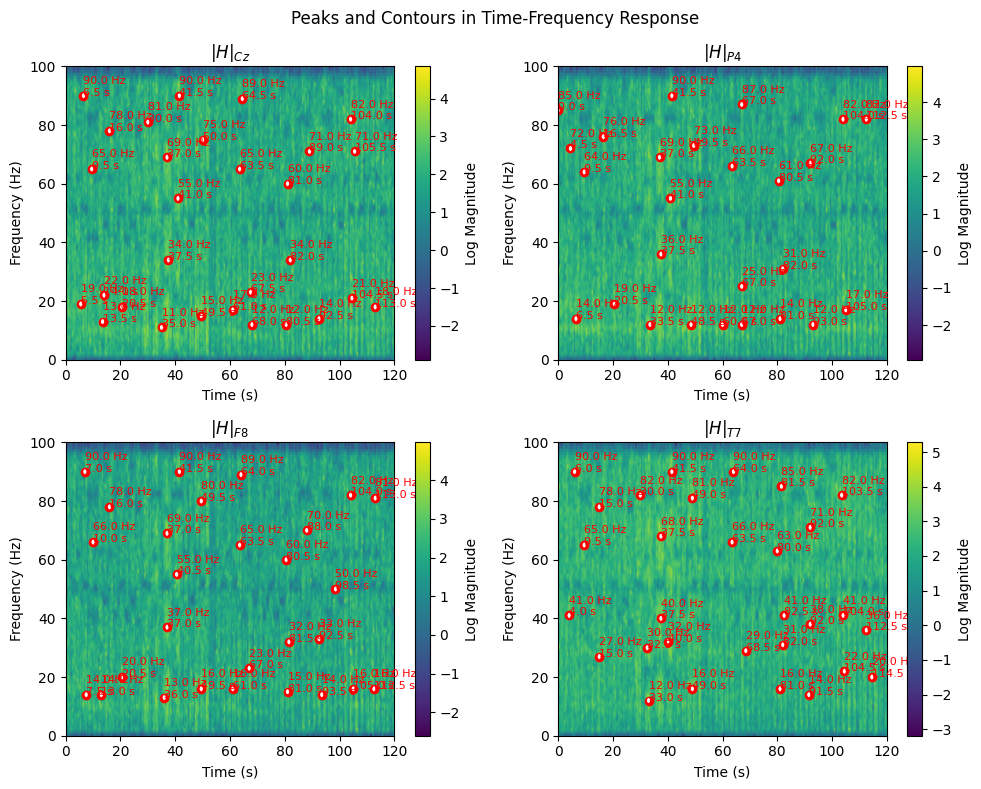


Channel: Cz
Peak at 11.00 Hz, 35.00 s with boundaries: {'time_min': 35.0, 'time_max': 35.0, 'freq_min': 11.0, 'freq_max': 11.0}
Peak at 12.00 Hz, 47.00 s with boundaries: {'time_min': 47.0, 'time_max': 47.0, 'freq_min': 12.0, 'freq_max': 12.0}
Peak at 19.00 Hz, 10.50 s with boundaries: {'time_min': 10.5, 'time_max': 10.5, 'freq_min': 19.0, 'freq_max': 19.0}
Peak at 19.00 Hz, 105.50 s with boundaries: {'time_min': 105.5, 'time_max': 105.5, 'freq_min': 19.0, 'freq_max': 19.0}
Peak at 70.00 Hz, 35.50 s with boundaries: {'time_min': 35.5, 'time_max': 35.5, 'freq_min': 70.0, 'freq_max': 70.0}
Peak at 74.00 Hz, 105.50 s with boundaries: {'time_min': 105.5, 'time_max': 105.5, 'freq_min': 74.0, 'freq_max': 74.0}

Channel: P4
Peak at 12.00 Hz, 48.00 s with boundaries: {'time_min': 48.0, 'time_max': 48.0, 'freq_min': 12.0, 'freq_max': 12.0}
Peak at 13.00 Hz, 34.50 s with boundaries: {'time_min': 34.5, 'time_max': 34.5, 'freq_min': 13.0, 'freq_max': 13.0}
Peak at 16.00 Hz, 8.00 s with boundaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter, label, find_objects
from scipy.ndimage import gaussian_filter

# Function to detect peaks with width consideration
def detect_peaks(H, width=10):
    # Apply Gaussian filter for smoothing
    H_smooth = gaussian_filter(np.abs(H), sigma=width)

    # Detect local maxima
    local_max = maximum_filter(H_smooth, size=width) == H_smooth
    labeled, num_objects = label(local_max)

    # Extract peak positions and their boundary edges
    peak_info = []
    for i in range(1, num_objects + 1):
        slice_x, slice_y = find_objects(labeled == i)[0]
        peak_region = H_smooth[slice_x, slice_y]
        peak_value = np.max(peak_region)
        peak_coords = np.unravel_index(np.argmax(peak_region), peak_region.shape)

        # Convert to global coordinates
        time_idx = slice_x.start + peak_coords[0]
        freq_idx = slice_y.start + peak_coords[1]
        time_peak = T[time_idx, freq_idx]
        freq_peak = F[time_idx, freq_idx]

        # Boundary edges
        boundaries = {
            'time_min': T[slice_x.start, slice_y.start],
            'time_max': T[slice_x.stop - 1, slice_y.stop - 1],
            'freq_min': F[slice_x.start, slice_y.start],
            'freq_max': F[slice_x.stop - 1, slice_y.stop - 1]
        }

        peak_info.append({
            'time': time_peak,
            'frequency': freq_peak,
            'peak_value': peak_value,
            'boundaries': boundaries,
            'indices': (time_idx, freq_idx)  # Store indices for contouring
        })

    return peak_info, labeled

# Define channels
channels = ['Cz', 'P4', 'F8', 'T7']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Loop through channels
for i, channel in enumerate(channels):
    H = results[channel]['transfer_function']
    ax = axes[i]

    # Detect peaks and get boundaries
    peaks, labeled = detect_peaks(H, width=5)

    # Plot the spectrogram
    c = ax.pcolormesh(T, F, np.log10(np.abs(H)), shading='gouraud', cmap='viridis')
    ax.set_title(r'$|H|_{%s}$' % channel)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')

    # Annotate detected peaks
    for peak in peaks:
        ax.plot(peak['time'], peak['frequency'], 'ro')  # Mark peak with red dot
        ax.annotate(f"{peak['frequency']:.1f} Hz\n{peak['time']:.1f} s",
                    (peak['time'], peak['frequency']), color='red', fontsize=8)

        # Safely get indices for contour drawing
        time_idx, freq_idx = peak['indices']
        if time_idx < labeled.shape[0] and freq_idx < labeled.shape[1]:
            mask = labeled == labeled[time_idx, freq_idx]
            ax.contour(T, F, mask, levels=[0.5], colors='white', linewidths=1.5)

    # Add colorbar
    fig.colorbar(c, ax=ax, label='Log Magnitude')

# Adjust layout and save the figure
fig.suptitle('Peaks and Contours in Time-Frequency Response')
plt.tight_layout()
plt.show()

# Print numerical boundaries of detected peaks
for channel, ax in zip(channels, axes):
    print(f"\nChannel: {channel}")
    H = results[channel]['transfer_function']
    peaks, _ = detect_peaks(H)
    for peak in peaks:
        print(f"Peak at {peak['frequency']:.2f} Hz, {peak['time']:.2f} s "
              f"with boundaries: {peak['boundaries']}")
